In [1]:
sys.path.append("..")
import os
import utils
import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
import pandas as pd
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.ticker import PercentFormatter
import glob

## General functions

In [2]:
def prepare_regional_data(data):
    m,n,r = data.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),data.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr)
    out_df['week'] = out_df.index % data.shape[1]
    out_df = out_df.rename(columns={0:'simulation'})
    out_df['simulation'] = out_df['simulation'].astype(int)
    out_df.set_index(['simulation', 'week'], inplace=True)
    return out_df

In [3]:
def generate_accumulated_age_infection_data():
    path = '../data/age_infections'
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    master_df =  pd.DataFrame(columns = ['week', 'Aldersgrupper (per 10 år)', 'Kvinner', 'Menn'])
    week = 1
    for f in csv_files:
        df = pd.read_csv(f)
        df['week'] = week
        week += 1
        master_df =master_df.append(df)
    master_df['infected'] = master_df['Kvinner'] + master_df['Menn']
    master_df['age_group'] = master_df['Aldersgrupper (per 10 år)']
    master_df = master_df[['week', 'age_group', 'infected']]
    df_age = master_df.set_index('age_group').pivot(columns="week", values='infected')
    df_age.to_csv('../data/infected_per_age_group_per_week_untreated.csv',index=False)

In [4]:
# Calculate percentiles
def calculate_cumulative_infected_percentiles(percentile_lim, new_deaths_age_groups, new_infected_age_groups):
    percentile_limit=percentile_lim
    new_deaths_all_age_groups = np.sum(new_deaths_age_groups, axis=2)
    deaths_cumulative = new_deaths_all_age_groups.cumsum(axis=1)
    deaths_mean = new_deaths_all_age_groups.mean(axis=0)
    deaths_mean_cumulative = deaths_cumulative.mean(axis=0)
    u_percentile_deaths = np.percentile(new_deaths_all_age_groups, percentile_limit, axis=0)
    l_percentile_deaths = np.percentile(new_deaths_all_age_groups, 100-percentile_limit, axis=0)
    u_percentile_deaths_cum = np.percentile(deaths_cumulative, percentile_limit, axis=0)
    l_percentile_deaths_cum = np.percentile(deaths_cumulative, 100-percentile_limit, axis=0)
    
    new_infected_all_age_groups =  np.sum(new_infected_age_groups, axis=2)
    infected_cumulative = new_infected_all_age_groups.cumsum(axis=1)
    infected_mean = new_infected_all_age_groups.mean(axis=0)
    infected_mean_cumulative = infected_cumulative.mean(axis=0)
    u_percentile_infected = np.percentile(new_infected_all_age_groups, percentile_limit, axis=0)
    l_percentile_infected = np.percentile(new_infected_all_age_groups, 100-percentile_limit, axis=0)
    u_percentile_infected_cum = np.percentile(infected_cumulative, percentile_limit, axis=0)
    l_percentile_infected_cum = np.percentile(infected_cumulative, 100-percentile_limit, axis=0)
    
    return [deaths_mean_cumulative, u_percentile_deaths_cum, l_percentile_deaths_cum, infected_mean_cumulative, u_percentile_infected_cum, l_percentile_infected_cum , deaths_cumulative, infected_cumulative]

In [5]:
# Norway data
def plot_age_distributions(data, start_week, max_weeks_real_data, dates, fpath):
    plt.style.use('seaborn-ticks')
    restrict_to_real_data_length = True
    fig, ax = plt.subplots(1, figsize=(8,6))

    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,0], label='0-17')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,1], label='18-44')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,2], label='45-54')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,3], label='55-64')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,4], label='65-74')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,5], label='75-84')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,6], label='85+'  )

    ax.legend(loc='upper left')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
    plt.gca().xaxis.set_tick_params(rotation =30)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid()
    ax.legend(loc='center right')
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.ylim((0,70))
    plt.savefig(fpath, dpi=fig.dpi, bbox_inches = 'tight')

In [6]:
# Define colormap
def generate_color_map():
    limits = [100, 200, 300, 500, 1000]

    reds = sns.color_palette('Reds')
    red0 = np.append(np.array(reds[0]), 1)
    red1 = np.append(np.array(reds[1]), 1)
    red2 = np.append(np.array(reds[2]), 1)
    red3 = np.append(np.array(reds[3]), 1)
    red4 = np.append(np.array(reds[4]), 1)
    red5 = np.append(np.array(reds[5]), 1)
    white = np.ones(shape=red0.shape) 

    min_value = 0
    max_value = limits[-1]
    mapping = np.linspace(min_value, max_value, 256)
    newcolors = np.empty((256, 4))
    newcolors[mapping < limits[0]] = white
    newcolors[mapping > limits[0]] = red1
    newcolors[mapping > limits[1]] = red2
    newcolors[mapping > limits[2]] = red3
    newcolors[mapping > limits[3]] = red4
    newcolors[mapping > limits[4]] = red5

    return limits, ListedColormap(newcolors)

# Load all data

In [7]:
# Read data and generate parameters
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)

In [8]:
# generate geodatefram for plotting
gdf = utils.generate_geopandas(population, paths.municipalities_geo)

In [9]:
# load data
# 0 : age_labels, 
# 1 : vaccines_available, 
# 2 : flow_scale, 
# 3 : contact_weights, 
# 4 : S_regions, 
# 5 : I_regions, 
# 6 : new_infected_regions,
# 7 : new_deaths_regions,
# 8 : V_regions,
# 9 : S_age_groups,
# 10: I_age_groups,
# 11: new_infected_age_groups,
# 12: new_deaths_age_groups,
# 13: vaccinated_age_groups,
# 14: dates
# ---------------------------------------------
# 15: df_x_regions
# 16: I_regions_cum
# 17: percentiles_age_groups
all_data = {}
all_policies = list(paths.keys())
paths ={'Infection-Based'  : 'results/500_simulations_infection_based_2021_06_05_01_28_48',
        'Population-Based' : 'results/500_simulations_susceptible_based_2021_06_05_01_28_09',
        'Age-Based'        : 'results/500_simulations_oldest_first_2021_06_05_01_28_41',
        'Contact-Based'    : 'results/500_simulations_contact_based_2021_06_05_01_28_48',
        'NIPH Policy'      : 'results/500_simulations_fhi_policy_2021_06_05_01_29_47',
        'Random Policy'    : 'results/500_simulations_random_2021_06_05_02_05_17',
        'Weighted'         : 'results/500_simulations_weighted_2021_06_05_14_52_43'
        }
for k, v in paths.items():
    all_data[k] = list(utils.read_csv(v))

Reading results ..
100%|██████████| 500/500 [00:03<00:00, 158.10it/s]
Reading results ..
100%|██████████| 500/500 [00:03<00:00, 156.00it/s]
Reading results ..
100%|██████████| 500/500 [00:02<00:00, 171.29it/s]
Reading results ..
100%|██████████| 500/500 [00:03<00:00, 128.73it/s]
Reading results ..
100%|██████████| 500/500 [00:03<00:00, 144.74it/s]
Reading results ..
100%|██████████| 500/500 [00:03<00:00, 144.93it/s]
Reading results ..
100%|██████████| 500/500 [00:03<00:00, 132.80it/s]


In [10]:
for k, v in paths.items():
    # Add additonal data 

    # df_x_regions
    X = np.insert(np.diff(all_data[k][8], axis=1), 0, 0, axis=1) # Need to this on vaccines since the first week is deleted when taking the difference of V for each week
    df_x_regions = prepare_regional_data(X)
    all_data[k].append(df_x_regions)

    # I cumulative percentiles
    I_regions_cum = prepare_regional_data(all_data[k][5].cumsum(axis=1))
    all_data[k].append(I_regions_cum)

    # I_regions_cum
    percentile=90
    all_data[k].append(calculate_cumulative_infected_percentiles(percentile, all_data[k][12], all_data[k][11]))

# Plot Vaccine distribution for different poilicies

In [14]:

policies = all_policies[0:3]# Can only use 3


plt.style.use('seaborn-ticks')
simulations = [0] # simulation starts at 0
weeks = [45, 70, 72] # weeks starts at 1

nrows=1
ncols=3

for sim in simulations:
    for week in weeks:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,12*nrows), sharex=True)
        col = 0 
        for i, value in enumerate(policies):
            x = all_data[value][15].loc[(sim,week)]
            x.index -= 1
            gdf[value] = x
            ax = axs[col]
            if value == 'Symptomatic-Infected':
                gdf.plot(ax=ax, column=value, facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap='Reds', legend=True, vmin=0,vmax=50)
            else:
                gdf[value+'_percentage'] = gdf[value]/gdf['population']
                gdf.plot(ax=ax, column=value+'_percentage', facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap='Blues', legend=True, vmin=0,vmax=0.2)
            ax.axis('off')
            col += 1
        plt.draw()
        plt.savefig(f"../plots/computational_study/regional_development/sim_{sim}_week_{week}.jpg", dpi=fig.dpi, bbox_inches = 'tight')
        plt.close()

# Compare objective comparison with Norwegian data

In [15]:
# Define colours
colors = sns.color_palette('Set2')
color_1 = 1
color_2 = 2

In [28]:
# Load norwegina data
df = pd.read_csv('../data/waves/world_daily_cases.csv')
df = df[df.country == "Norway"].fillna(0)

## Mean of simulations - accumulated fatalities

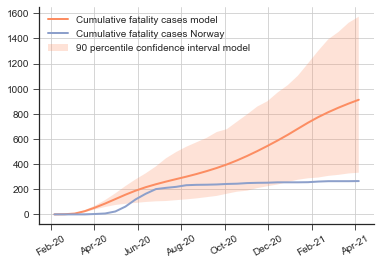

In [33]:
policy = all_policies[0]
dates = all_data[policy][14]
[deaths_mean_cumulative, u_percentile_deaths_cum, l_percentile_deaths_cum, infected_mean_cumulative, u_percentile_infected_cum, l_percentile_infected_cum , deaths_cumulative, infected_cumulative] = all_data[policy][17]

plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = int(62/2)
fig, ax = plt.subplots(1)

if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_deaths_cum[:max_weeks_real_data], l_percentile_deaths_cum[:max_weeks_real_data], facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')

else:
    ax.plot(dates[:-1], deaths_mean_cumulative[:-1], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])
    ax.fill_between(dates, u_percentile_deaths_cum, l_percentile_deaths_cum, facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')

ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/mean_match_deaths.png", bbox_inches='tight', dpi=150)

## Mean of simulations - accumulated cases

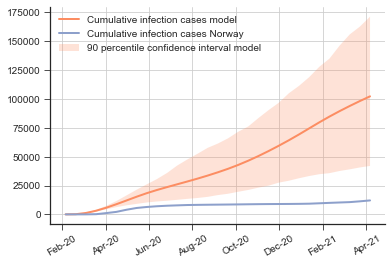

In [35]:
plt.style.use('seaborn-ticks')

policy = all_policies[0]
dates = all_data[policy][14]
[deaths_mean_cumulative, u_percentile_deaths_cum, l_percentile_deaths_cum, infected_mean_cumulative, u_percentile_infected_cum, l_percentile_infected_cum , deaths_cumulative, infected_cumulative] = all_data[policy][17]

restrict_to_real_data_length = True
max_weeks_real_data = int(62/2)
sim = 1 

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_infected_cum[:max_weeks_real_data], l_percentile_infected_cum[:max_weeks_real_data], facecolor=colors[1], alpha=0.25, label='90 percentile confidence interval model')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])
else:
    ax.plot(dates[:-1], infected_mean_cumulative[:-1], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.fill_between(dates, u_percentile_infected_cum, l_percentile_infected_cum, facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/mean_match_cases.png", bbox_inches='tight', dpi=150)

## One simulation - accumulated cases

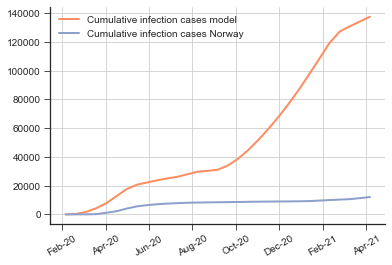

In [37]:
policy = all_policies[0]
dates = all_data[policy][14]
[deaths_mean_cumulative, u_percentile_deaths_cum, l_percentile_deaths_cum, infected_mean_cumulative, u_percentile_infected_cum, l_percentile_infected_cum , deaths_cumulative, infected_cumulative] = all_data[policy][17]

plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = int(62/2)
sim = 2  # Good case:2, Bad case: 0


fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_cumulative[sim][:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])
else:
    ax.plot(dates[:-1], infected_cumulative[sim][:-1], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/good_match_cases.png", bbox_inches='tight', dpi=150)

## One simulation - accumulated fatalities

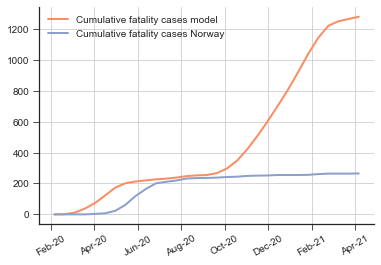

In [38]:
policy = all_policies[0]
dates = all_data[policy][14]
[deaths_mean_cumulative, u_percentile_deaths_cum, l_percentile_deaths_cum, infected_mean_cumulative, u_percentile_infected_cum, l_percentile_infected_cum , deaths_cumulative, infected_cumulative] = all_data[policy][17]

plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = int(62/2)
simulation = 2

fig, ax = plt.subplots(1)
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_cumulative[simulation][:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])

else:
    ax.plot(dates[:-1], deaths_cumulative[simulation][:-1], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])

ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/good_match_deaths.png", bbox_inches='tight', dpi=150)

# Regional comparison with Norwegian numbers

In [39]:
# read data 
df = pd.read_csv('../data/infected_municipalities_covidnorway.csv')

# aggregate data across bydeler
df_municipalities = df.groupby(['date', 'kommune_no']).agg('sum')
df_municipalities.reset_index(inplace=True)

# Remove unknown municipalities
f1 = df_municipalities['kommune_no'] != 9998 
f2 = df_municipalities['kommune_no'] != 9999
df_municipalities = df_municipalities[f1 & f2]

# transform to weekly data 
df_municipalities['date'] = pd.to_datetime(df_municipalities['date'])
df_municipalities['week'] = df_municipalities['date'].dt.isocalendar().week
df_municipalities['year'] = df_municipalities['date'].dt.isocalendar().year
resample_dict ={'cases':'last', 'date':'last'}
df_municipalities = df_municipalities.groupby(['year', 'week', 'kommune_no']).agg(resample_dict)
df_municipalities.reset_index(inplace=True)
df_municipalities['week'] = np.where(df_municipalities['year'] > 2020, df_municipalities['week'] + 53, df_municipalities['week'])
df_municipalities = df_municipalities[['week', 'cases', 'kommune_no']]

# transform data
df_municipalities = df_municipalities.set_index('week').pivot(columns="kommune_no", values='cases')
mapper = {df_municipalities.columns[i]: i+1 for i in range(len(df_municipalities.columns))}
df_municipalities = df_municipalities.rename(mapper, axis=1).reset_index()
df_municipalities = df_municipalities.set_index(['week']) 
df_municipalities.index = df_municipalities.index - 8 # to get same start week as simulation (simulation starts in week 9, data starts in week 13.

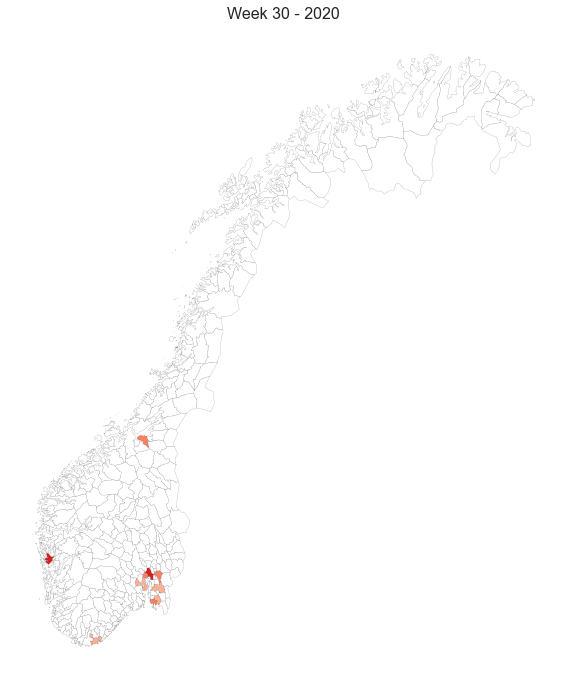

In [41]:
# Plot policies
simulations = 2 
week = int(60/2)  # 5 <= x <= 67 #  starting from simulation start date
policy = 'Norway' # 'Norway' for norwegina numbers
max_cols = 3
limits, my_colormap = generate_color_map()

fig, ax = plt.subplots(1, figsize=(12,12))
I = all_data[policy][16].loc[(sim,week)] if policy != 'Norway' else df_municipalities.loc[week]
I.index -= 1
gdf[week] = I
gdf[week] =  gdf[week].apply(
lambda x: 0 if x < limits[0] else 
(limits[0] if x < limits[1] else 
(limits[1] if x < limits[2] else 
(limits[2] if x < limits[3] else 
(limits[3] if x < limits[4] else 
limits[4] )))))

gdf.plot(ax=ax, column=week, facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap=my_colormap, legend=False, vmin=0, vmax=limits[-1])
ax.axis('off')
year = 2020 if week <53 else 2021
ax.set_title(f'Week {week %53} - {year}', size=16)
date = dates[week] 
plt.draw()
plt.savefig(f"../plots/computational_study/norwegian_numbers_comparison_regional/{policy}_week_{week}.jpg", dpi=fig.dpi, bbox_inches = 'tight')

# Age comparison with Norwegian numbers

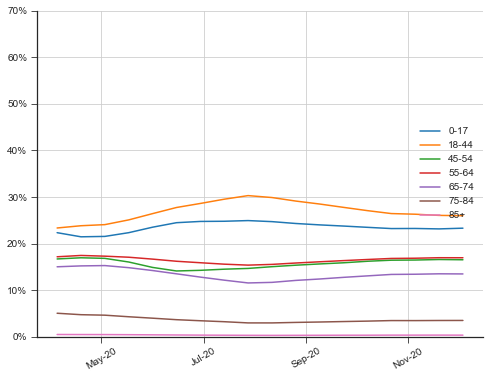

In [44]:
start_week = 5 # weeks from 24.2 
max_weeks_real_data = int(44/2)
policy = all_policies[0]
fpath = '../plots/computational_study/norwegian_numbers_comparison_age/model.jpg'

dates = all_data[policy][14]

I_age_groups = all_data[policy][10]
I_mean = np.mean(I_age_groups, axis=0) 
normed_I_mean= normalize(I_mean, axis=1, norm='l1') * 100

plot_age_distributions(normed_I_mean, start_week, max_weeks_real_data, dates, fpath)

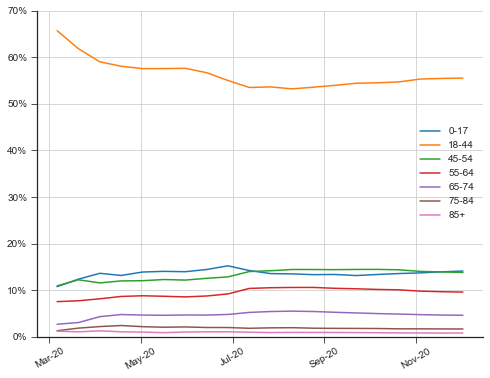

In [45]:
start_week = int(6/2) # weeks from 24.2 
max_weeks_real_data = int(45/2)
fpath = '../plots/computational_study/norwegian_numbers_comparison_age/norway.jpg'

I_mean_norway = pd.read_csv('../data/infected_per_age_group_per_week.csv').to_numpy().T
I_mean_norway = I_mean_norway[1:]*100
I_mean_norway = I_mean_norway.cumsum(axis=0)
normed_I_mean_Norway = normalize(I_mean_norway, axis=1, norm='l1') * 100
normed_I_mean_Norway.shape

plot_age_distributions(normed_I_mean_Norway, start_week, max_weeks_real_data, dates, fpath)

In [46]:
mean_across_weeks_model  = np.mean(normed_I_mean, axis=0)
mean_across_weeks_norway = np.mean(normed_I_mean_Norway, axis=0)
pop_per_age_group = population.sum(axis=0)[2:-1].values 
normed_pop_per_age_group = (pop_per_age_group /np.sum(pop_per_age_group)) * 100

array_tuple = (age_labels, mean_across_weeks_model, mean_across_weeks_norway, pop_per_age_group)
arrays = np.vstack(array_tuple)
df = pd.DataFrame(arrays)
df.columns = age_labels
df

,0-17,18-44,45-54,55-64,65-74,75-84,85+
0,0-17,18-44,45-54,55-64,65-74,75-84,85+
1,27.578286,26.359943,14.540682,15.48821,11.778749,3.423784,0.830345
2,14.923256,54.631606,13.71558,9.460298,4.596593,1.762088,0.910578
3,1111690,1918320,746639,648978,539996,308286,116190


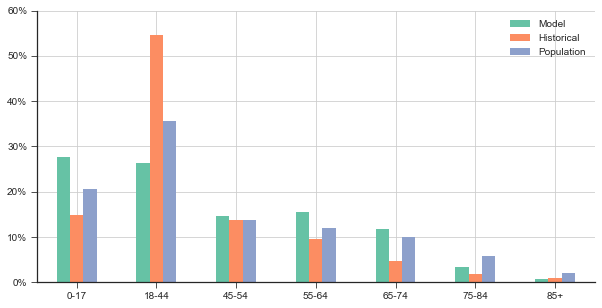

In [47]:
plt.style.use('seaborn-ticks')

df = pd.DataFrame({
"Model":mean_across_weeks_model,
"Historical":mean_across_weeks_norway,
"Population":normed_pop_per_age_group}, 
index=age_labels
)

ax = df.plot(kind="bar", stacked=False, figsize=(10,5), color=sns.color_palette('Set2'))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
ax.legend(loc='upper right')
ax.yaxis.set_major_formatter(PercentFormatter())
plt.ylim((0,60))
plt.gca().xaxis.set_tick_params(rotation =0)

plt.savefig('../plots/computational_study/norwegian_numbers_comparison_age/cases_per_age_group', bbox_inches = 'tight')

# Compare policies - objectives

In [48]:
plt.style.use('seaborn-ticks')

policies = 'infection_5'
dates = all_data[policy][14]
[deaths_mean_cumulative, u_percentile_deaths_cum, l_percentile_deaths_cum, infected_mean_cumulative, u_percentile_infected_cum, l_percentile_infected_cum , deaths_cumulative, infected_cumulative] = all_data[policy][17]

restrict_to_real_data_length = True
max_weeks_real_data = 63
sim = 1 

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_infected_cum[:max_weeks_real_data], l_percentile_infected_cum[:max_weeks_real_data], facecolor=colors[1], alpha=0.25, label='90 percentile confidence interval model')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])
else:
    ax.plot(dates[:-1], infected_mean_cumulative[:-1], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.fill_between(dates, u_percentile_infected_cum, l_percentile_infected_cum, facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/mean_match_cases.png", bbox_inches='tight', dpi=150)

AttributeError: 'DataFrame' object has no attribute 'cumulative_total_cases'